In [2]:
%load_ext autoreload
%autoreload 2

#@title Check if MuJoCo installation was successful

import distutils.util
import os
import subprocess
if subprocess.run('nvidia-smi').returncode:
  raise RuntimeError(
      'Cannot communicate with GPU. '
      'Make sure you are using a GPU Colab runtime. '
      'Go to the Runtime menu and select Choose runtime type.')

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
  with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
    f.write("""{
    "file_format_version" : "1.0.0",
    "ICD" : {
        "library_path" : "libEGL_nvidia.so.0"
    }
}
""")

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

try:
  print('Checking that the installation succeeded:')
  import mujoco
  mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')

print('Installation successful.')

%env CUDA_VISIBLE_DEVICES=1

from ambersim.envs.a1 import A1Env
from ambersim.base import State
from brax import envs
import jax
from jax import numpy as jp
import numpy as np
import mujoco
from mujoco import mjx

# Graphics and plotting.
# print('Installing mediapy:')
# !command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
# !pip install -q mediapy
import mediapy as media

from brax.training.agents.ppo import train as ppo
from brax.training.agents.ppo import networks as ppo_networks
import functools
from matplotlib import pyplot as plt

from datetime import datetime


Wed Nov  8 16:14:37 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.147.05   Driver Version: 525.147.05   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0  On |                  Off |
| 58%   50C    P8    27W / 450W |   1345MiB / 24564MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  On   | 00000000:41:00.0 Off |                  Off |
| 60%   

In [3]:
# instantiate the environment
env_name = "a1"
envs.register_environment("a1", A1Env)
env = envs.get_environment(env_name)

In [1]:
# define the jit reset/step functions
jit_reset = jax.jit(env.reset)
jit_step = jax.jit(env.step)

# instantiate the renderer
renderer = mujoco.Renderer(env.model)
def get_image(state: State, camera: str) -> np.ndarray:
  """Renders the environment state."""
  d = mujoco.MjData(env.model)
  # write the mjx.Data into an mjData object
  mjx.device_get_into(d, state.pipeline_state)
  mujoco.mj_forward(env.model, d)
  # use the mjData object to update the renderer
  renderer.update_scene(d, camera=camera)
  return renderer.render()

# initialize the state
state = jit_reset(jax.random.PRNGKey(0))
rollout = [state]
images = [get_image(state, camera='track')]
render_every = 2

# grab a trajectory
for i in range(250):
  ctrl = jp.zeros(env.sys.nu)
  %time state = jit_step(state, ctrl)
  rollout.append(state)
  if i % render_every == 0:
    images.append(get_image(state, camera='track'))

media.show_video(images, fps=1.0 / env.dt)

print(len(images))

NameError: name 'jax' is not defined

In [70]:
# rollout[-1].pipeline_state.qpos[7:]- env._default_ap_pose
# env.model.actuator_gaintype = jp.ones_like(env.model.actuator_gaintype)

# rollout[-1].pipeline_state.qfrc_actuator
rollout[-1].pipeline_state.qpos[7:], env._default_ap_pose
# jp.linalg.pinv(rollout[-1].pipeline_state.actuator_moment.T) @ rollout[-1].pipeline_state.qfrc_actuator

(Array([ 0.15101999,  0.5536807 , -1.8687341 , -0.14324486,  0.5489383 ,
        -1.8694613 , -0.07420097,  0.86128813, -1.9421877 ,  0.07591714,
         0.85418   , -1.9496917 ], dtype=float32),
 array([ 0. ,  0.9, -1.8,  0. ,  0.9, -1.8,  0. ,  0.9, -1.8,  0. ,  0.9,
        -1.8]))

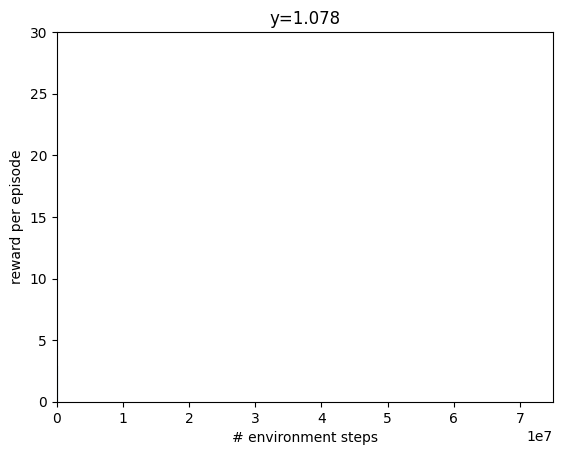

Exception ignored in: <function _xla_gc_callback at 0x7f864c9aa7a0>
Traceback (most recent call last):
  File "/home/preston/miniconda3/envs/ambersim/lib/python3.11/site-packages/jax/_src/lib/__init__.py", line 101, in _xla_gc_callback
    def _xla_gc_callback(*args):
    
KeyboardInterrupt: 


In [4]:
make_networks_factory = functools.partial(
    ppo_networks.make_ppo_networks,
        policy_hidden_layer_sizes=(128, 128, 128, 128))
train_fn = functools.partial(
      ppo.train,
      num_timesteps=60_000_000, num_evals=3, reward_scaling=1,
      episode_length=1000, normalize_observations=True,
      action_repeat=1, unroll_length=20, num_minibatches=8, gae_lambda=0.95,
      num_updates_per_batch=4, discounting=0.99, learning_rate=3e-4,
      entropy_cost=1e-2, num_envs=4096, batch_size=1024,
      network_factory=make_networks_factory,
      num_resets_per_eval=10,
      seed=0)

def progress(num_steps, metrics):
  times.append(datetime.now())
  x_data.append(num_steps)
  y_data.append(metrics['eval/episode_reward'])
  ydataerr.append(metrics['eval/episode_reward_std'])

  plt.xlim([0, train_fn.keywords['num_timesteps'] * 1.25])
  plt.ylim([min_y, max_y])

  plt.xlabel('# environment steps')
  plt.ylabel('reward per episode')
  plt.title(f'y={y_data[-1]:.3f}')

  plt.errorbar(
      x_data, y_data, yerr=ydataerr)
  plt.show()

x_data = []
y_data = []
ydataerr = []
times = [datetime.now()]
max_y, min_y = 30, 0

# Reset environments since internals may be overwritten by tracers from the
# domain randomization function.
env = envs.get_environment(env_name)
eval_env = envs.get_environment(env_name)
make_inference_fn, params, _= train_fn(environment=env,
                                       progress_fn=progress,
                                       eval_env=eval_env)

print(f'time to jit: {times[1] - times[0]}')
print(f'time to train: {times[-1] - times[1]}')